# TUTORIAL: 
# Data assimilation using real experimental data

We can now put everything we have learned together. 

We can investigate two scenarios:

A) Assume that we have access to the post-processed data and assimilate it. This situation simplifies the problem as the experimental data is not biased (see tutorial TA_azimuthal_data to see how the raw data is biased).
-   Truth: post-processed data 
-   Observations: post-processed data + noise (possibly coloured noise)

B) Assume a realistic setting in which the post-processed data is not available on the fly to input to the data assimilation algorithm. Here, we need to address the issue of biased observations.
-   Truth: post-processed data
-   Observations: raw data

In this tutorial we will work with option B. For option A go to the tutorial ```10_DA_annular_ideal.ipynb```.

In [1]:
import numpy as np
import os

rng = np.random.default_rng(0)


if os.path.isdir('/mscott/'):
    data_folder = '/mscott/an553/data/'  # set working directory to 
else:
    data_folder = "../data/"

## 1. Load data 
Create the reference truth and the observations.

*The code below can be compacted with the function ```create_truth```, which outputs a dictionary:*
```
  
from essentials.create import create_truth
truth = create_truth(filename, t_start, t_stop, dt_obs, post_processed=False)
```

In [2]:
from essentials.create import create_truth
from essentials.physical_models import Annular
from essentials.plotResults import plot_truth

ER = 0.5125  
filename = data_folder + 'annular/ER_{}'.format(ER)

# Select the observations time-window
t_start = 2* Annular.t_transient 
t_stop = t_start + Annular.t_CR * 5
Nt_obs = 55

truth = create_truth(filename, t_start, t_stop, Nt_obs, post_processed=False)
# plot_truth(**truth)


## 2. Define the forecast model
This is the physical model which we will use to model the true data.
Here, we select the filter parameters and create ensemble


In [3]:
from essentials.create import create_ensemble

filter_params = {'m': 10, 
                 'inflation': 1.002,
                 'std_psi': 0.3,
                 'std_a': dict(nu=(40., 50.),
                               c2beta=(5, 20),
                               kappa=(1.E-4, 1.3E-4),
                               epsilon=(0.0001, 0.03),
                               omega=(1090 * 2 * np.pi, 1100 * 2 * np.pi),
                               theta_b=(0.5, 0.7),
                               theta_e=(0.5, 0.8)
                               )}

ensemble = create_ensemble(model=Annular, **filter_params)

ensemble_no_bias = ensemble.copy()


## 4. Train an ESN to model the model bias
The procedure is the following

&emsp; i. Initialise ESN Bias class object
&emsp; ii. Create synthetic bias to use as training data 
&emsp; iii. Train the ESN
&emsp; iv. Create washout data

In [4]:
from essentials.create import create_bias_training_dataset
from essentials.bias_models import ESN

train_params = dict(bias_model=ESN, 
                    upsample=5,
                    N_units=50,
                    N_wash=3,
                    t_train=ensemble.t_CR * 10,
                    bayesian_update=True,
                    biased_observations=True,
                    m=ensemble.m,
                    # Training data generation options
                    augment_data=True,
                    L=10,
                    noise=0.1, 
                    # Hyperparameter search ranges
                    rho_range=(0.5, 1.1),
                    sigma_in_range=(np.log10(1e-5), np.log10(1e1)),
                    tikh_range=[1e-16]
                    )

# 4.1. Initialise the ESN
ensemble.init_bias(**train_params)

# 4.2. Create training data
train_data = create_bias_training_dataset(truth['y_raw'], truth['y_true'], ensemble, **train_params)


In [5]:
print(ensemble.bias.N_dim,
      ensemble.bias.N_dim_in, 
      ensemble.bias.m,
      ensemble.bias.hist.shape)

8 8 10 (1, 8, 1)


observed_idx [0 1 2 3 4 5 6 7] -> [4 5 6 7]
t_train 0.1 -> 0.1
t_val 0.1 -> 0.01
augment_data True -> True
bayesian_update True -> True
biased_observations True -> True
L 10 -> 10

 ----------------- HYPERPARAMETER SEARCH ------------------
 4x4 grid and 4 points with Bayesian Optimization
		 rho	 sigma_in	 tikh	 MSE val 
1	 5.000e-01	 1.000e-05	 1.000e-16	 -4.1607
2	 5.000e-01	 1.000e-03	 1.000e-16	 -3.9115
3	 5.000e-01	 1.000e-01	 1.000e-16	 -3.9295
4	 5.000e-01	 1.000e+01	 1.000e-16	 -4.8230
5	 7.000e-01	 1.000e-05	 1.000e-16	 -4.1702
6	 7.000e-01	 1.000e-03	 1.000e-16	 -4.0509
7	 7.000e-01	 1.000e-01	 1.000e-16	 -4.0148
8	 7.000e-01	 1.000e+01	 1.000e-16	 -4.4151
9	 9.000e-01	 1.000e-05	 1.000e-16	 -4.0827
10	 9.000e-01	 1.000e-03	 1.000e-16	 -3.9760
11	 9.000e-01	 1.000e-01	 1.000e-16	 -3.9478
12	 9.000e-01	 1.000e+01	 1.000e-16	 -4.0736
13	 1.100e+00	 1.000e-05	 1.000e-16	 -2.4807
14	 1.100e+00	 1.000e-03	 1.000e-16	 -1.1193
15	 1.100e+00	 1.000e-01	 1.000e-16	 -2.0071
16	 1.100e

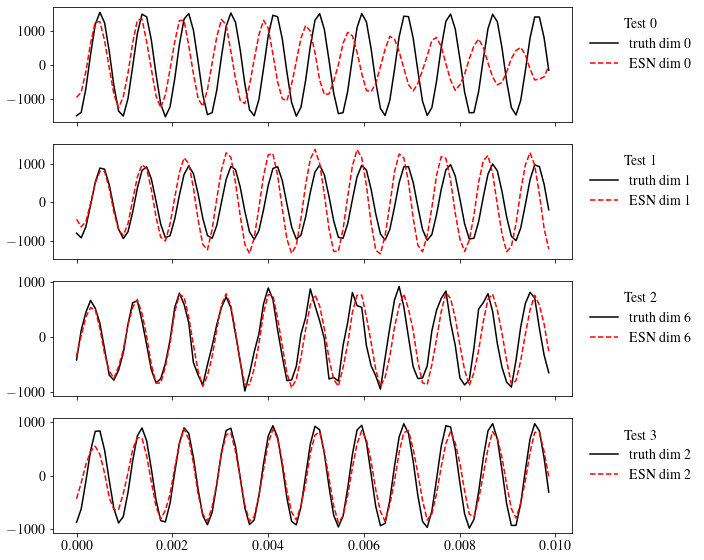

In [6]:

# 4.3. Train the ESN
# The training convergence, hyperparameter optimization and testing results are saved in a pdf file in figs_ESN folder.
ensemble.bias.train_bias_model(**train_data) 

In [7]:
print(ensemble.bias.N_dim,
      ensemble.bias.N_dim_in, 
      ensemble.bias.m,
      ensemble.bias.hist.shape,
      ensemble.bias.u.shape,
      ensemble.bias.r.shape,
      ensemble.bias.bayesian_update)

8 8 10 (1, 8, 10) (8, 10) (50, 10) True


**4.4. Create washout data**

We retrieve from the raw data a ```N_wash``` number of observations to use for initialising the ESN, i.e., to perform the washout. 
The ESN initialization must be before the fist observation.

In [8]:
from essentials.create import create_washout

ensemble.t_init = truth['t_obs'][0]
ensemble.bias.t_init = ensemble.t_init - 2 * Nt_obs * truth['dt']

wash_t, wash_obs = create_washout(bias_case=ensemble.bias, **truth)


In [9]:

print(ensemble.bias.u)

[[-147.48266353 -699.84413352 -707.94662254   16.42645617  695.48294896
  -188.64185949 -558.2966576    44.343002    645.23849703  519.91089395]
 [ -54.37600309 -603.97298446 -256.48675997  754.87806114  285.2816835
   396.68964844    4.92009488  572.26723981  910.1511263   454.05784332]
 [ 117.25108206  119.83142476  487.45918754  744.64437346 -431.60482551
   558.27513635  576.30675392  527.17607377  271.11756351  -56.51939705]
 [  43.84701244  567.42897124  231.84235906 -745.96530406 -288.37864991
  -382.73647554  -22.60947051 -582.67268208 -897.51335937 -469.37454897]
 [-155.95692316 -748.80734067 -713.67675027   17.30214216  641.90238833
  -167.33096779 -546.01726026   68.25986479  634.00155088  452.06848666]
 [ -75.94676791 -644.98663847 -293.69761383  719.28963486  261.22552538
   411.14803048   -3.56349595  573.65211471  899.66082165  420.03097217]
 [  61.35242067   53.03358266  402.62022934  702.49805636 -431.19034266
   533.85781794  539.01856503  502.78693065  246.06093038  

## 5. Apply data assimilation
We now have all the ingredients to start our data assimilation algorithm.

In [10]:
ensemble_ESN = ensemble.copy()


In [12]:
from essentials.DA import dataAssimilation

std_obs = 0.1

kwargs = dict(y_obs=truth['y_obs'], t_obs=truth['t_obs'], std_obs=std_obs, 
              wash_obs=wash_obs, wash_t=wash_t)


ensemble_ESN.filter = 'rBA_EnKF'
ensemble_ESN.regularization_factor = 2.
ensemble_no_bias.filter ='EnSRKF'


out = []
for ens in [ensemble_no_bias, ensemble_ESN]:
# for ens in [ensemble_ESN]:
    ens = ens.copy()
    ens.bias.update_reservoir = False
    filter_ens = dataAssimilation(ens, **kwargs.copy())
    
    #Forecast the ensemble further without assimilation
    Nt_extra = int(filter_ens.t_CR / filter_ens.dt) + 1
    
    psi, t = filter_ens.time_integrate(Nt_extra)
    filter_ens.update_history(psi, t)
    
    y = filter_ens.get_observable_hist(Nt_extra)
    b, t_b = filter_ens.bias.time_integrate(t=t, y=y)
    filter_ens.bias.update_history(b, t_b)
    
    out.append(filter_ens)
    # out[-1] = filter_ens



 ------------------ Annular Model Parameters ------------------ 
	 ER = 0.5
	 Nq = 4
	 c2beta = 12.5
	 dt = 1.95313e-05
	 epsilon = 0.01505
	 kappa = 0.000115
	 n = 1.0
	 nu = 45.0
	 omega = 6880.09
	 theta_b = 0.6
	 theta_e = 0.65

 ----------------  Bias model parameters ----------------  
 Bias model: NoBias

 -------------------- ASSIMILATION PARAMETERS -------------------- 
 	 Filter = EnSRKF  
	 bias = NoBias 
 	 m = 10 
 	 Time steps between analysis = None 
 	 Inferred params = ['nu', 'c2beta', 'kappa', 'epsilon', 'omega', 'theta_b', 'theta_e'] 
 	 Inflation = 1.002 
 	 Ensemble std(psi0) = 0.3
 	 Ensemble std(alpha0) = {'nu': (40.0, 50.0), 'c2beta': (5, 20), 'kappa': (0.0001, 0.00013), 'epsilon': (0.0001, 0.03), 'omega': (6848.671984825749, 6911.503837897545), 'theta_b': (0.5, 0.7), 'theta_e': (0.5, 0.8)}
 	 Number of analysis steps = 47, t0=0.99998046875, t1=1.04939453125
 --------------------------------------------
Elapsed time to first observation: 6.811324119567871 s
Ass

ValueError: operands could not be broadcast together with shapes (10851,4) (10851,8,10) 

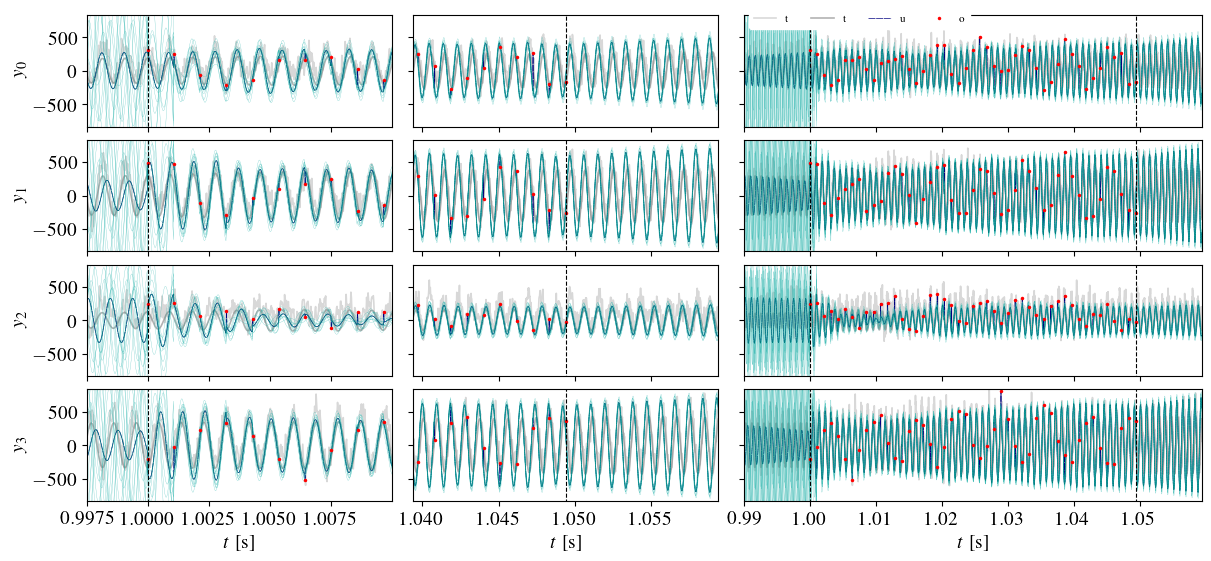

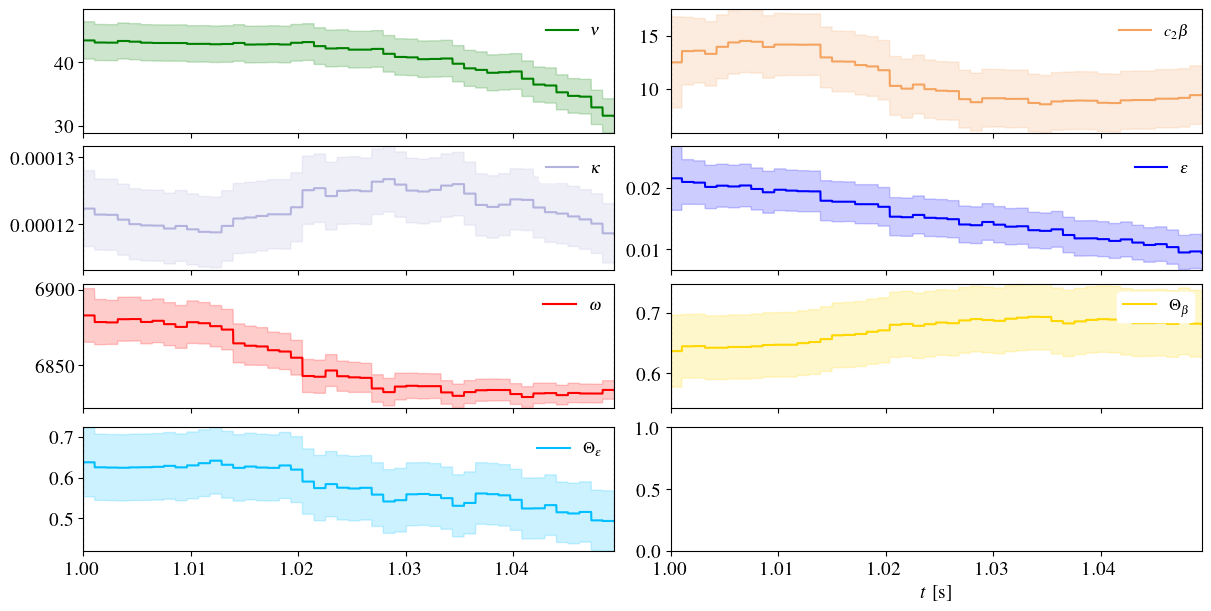

In [14]:
from essentials.plotResults import plot_timeseries, plot_parameters
# 
# truth = dict(y_raw=y_raw, y_true=y_true, t=t_true, dt=dt_t,
#              t_obs=t_true[obs_idx], y_obs=y_raw[obs_idx], dt_obs=dt_obs * dt_t,
#              std_obs=std_obs, wash_t=wash_t, wash_obs=wash_obs)

for filter_ens in out:
    plot_timeseries(filter_ens, truth)
    plot_parameters(filter_ens, truth)